In [3]:
import json
import os
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *
from relation_graph import *
import logging
import torch
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter
if isnotebook():
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO,
                    datefmt="%Y-%m-%d %H:%M")
logger = logging.getLogger(__name__)

import os
os.environ['QT_QPA_PLATFORM']='offscreen'

### Data Loader
Loading all created data long with gSCAN into memory.

In [4]:
gSCAN_data_file = "gSCAN-compositional_splits/dataset.txt"
gSCAN_data_json = json.load(open(os.path.join("../../data-files/", gSCAN_data_file)))

In [5]:
p1_path_to_data = "../../data-files/ReaSCAN-compositional-p1/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {p1_path_to_data}...")
p1_data_json = json.load(open(p1_path_to_data, "r"))

p2_path_to_data = "../../data-files/ReaSCAN-compositional-p2/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {p2_path_to_data}...")
p2_data_json = json.load(open(p2_path_to_data, "r"))

p3_path_to_data = "../../data-files/ReaSCAN-compositional-p3/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {p3_path_to_data}...")
p3_data_json = json.load(open(p3_path_to_data, "r"))

p3_rd_path_to_data = "../../data-files/ReaSCAN-compositional-p3-rd/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {p3_rd_path_to_data}...")
p3_rd_data_json = json.load(open(p3_rd_path_to_data, "r"))

2021-05-20 17:00 Reading dataset from file: ../../data-files/ReaSCAN-compositional-p1/data-compositional-splits.txt...
2021-05-20 17:00 Reading dataset from file: ../../data-files/ReaSCAN-compositional-p2/data-compositional-splits.txt...
2021-05-20 17:01 Reading dataset from file: ../../data-files/ReaSCAN-compositional-p3/data-compositional-splits.txt...
2021-05-20 17:02 Reading dataset from file: ../../data-files/ReaSCAN-compositional-p3-rd/data-compositional-splits.txt...


#### 1. Action Sequence Length Analyses
Let us see if aciton sequence is similarily distributed across these tasks. We don't want them to distribute differently, as we know longer sequence is definitely harder.

In [17]:
gSCAN_action_lengths = []
for i in range(0, len(gSCAN_data_json["examples"]["train"])):
    gSCAN_action_lengths.append(len(gSCAN_data_json["examples"]["train"][i]["target_commands"].split(",")))

# Let us look at sequence length in each training split of these generated sets.
p1_action_lengths = []
for i in range(0, len(p1_data_json["examples"]["train"])):
    p1_action_lengths.append(len(p1_data_json["examples"]["train"][i]["target_commands"].split(",")))
    
p2_action_lengths = []
for i in range(0, len(p2_data_json["examples"]["train"])):
    p2_action_lengths.append(len(p2_data_json["examples"]["train"][i]["target_commands"].split(",")))
    
p3_action_lengths = []
for i in range(0, len(p3_data_json["examples"]["train"])):
    p3_action_lengths.append(len(p3_data_json["examples"]["train"][i]["target_commands"].split(",")))
    
p3_rd_action_lengths = []
for i in range(0, len(p3_rd_data_json["examples"]["train"])):
    p3_rd_action_lengths.append(len(p3_rd_data_json["examples"]["train"][i]["target_commands"].split(",")))

In [97]:
from collections import Counter
bin_width = 8
upper_bound = (max(p3_rd_action_lengths)//bin_width)+1
def get_freq_list(action_lengths, bin_width=bin_width, upper_bound=upper_bound):
    _freq = Counter()
    for x in action_lengths:
        _freq[(x - 1) // bin_width] += 1
    _freq_list = []
    for i in range(0, upper_bound):
        if i in _freq:
            _freq_list += [_freq[i]] 
        else:
            _freq_list += [0]
    return _freq_list

gSCAN_freq_list = get_freq_list(gSCAN_action_lengths)
p1_freq_list = get_freq_list(p1_action_lengths)
p2_freq_list = get_freq_list(p2_action_lengths)
p3_freq_list = get_freq_list(p3_action_lengths)
p3_rd_freq_list = get_freq_list(p3_rd_action_lengths)

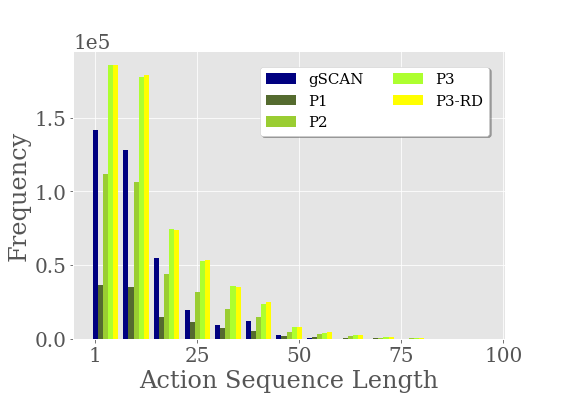

In [134]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 20}
plt.rc('font', **font)

X = np.arange(len(p2_freq_list))
X = X*1.5
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, gSCAN_freq_list, color = 'navy', width = 0.25, label='gSCAN')
ax.bar(X + 0.25, p1_freq_list, color = 'darkolivegreen', width = 0.25, label='P1')
ax.bar(X + 0.50, p2_freq_list, color = 'yellowgreen', width = 0.25, label='P2')
ax.bar(X + 0.75, p3_freq_list, color = 'greenyellow', width = 0.25, label='P3')
ax.bar(X + 1.0, p3_rd_freq_list, color = 'yellow', width = 0.25, label='P3-RD')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.legend(loc='upper right', bbox_to_anchor=(1.15,1.18), facecolor='white',
           ncol=2, fancybox=True, shadow=True, fontsize=15)
ax.set_ylabel('Frequency')
ax.set_xlabel('Action Sequence Length')
plt.xticks([0,5,10,15,20], ["1", "25", "50", "75", "100"])
# plt.show()
plt.savefig("../../data-files/Analysis-Result/action_sequence_length",dpi=1000, bbox_inches='tight')

### ReaSCAN Analyses
This file contains statistics analysis of the generated ReaSCAN by comparing to gSCAN.

In [18]:
external_data_dir = "../../data-files/"
ReaSCAN_data_file = "ReaSCAN-compositional-p1/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(os.path.join(external_data_dir, ReaSCAN_data_file)))

In [ ]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

command: push,the,big,blue,circle,cautiously


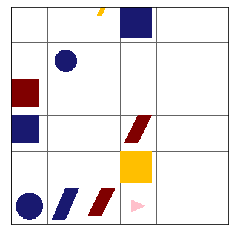

In [56]:
example = ReaSCAN_data_json["examples"]["train"][random.randint(0, len(ReaSCAN_data_json["examples"]["train"])-1)]
command = example["command"]
print(f"command: {command}")
situation = example["situation"]
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world.clear_situation()
for obj_idx, obj in situation["placed_objects"].items():
    world.place_object(
        Object(size=int(obj["object"]["size"]), color=obj["object"]["color"], shape=obj["object"]["shape"]), 
        position=Position(row=int(obj["position"]["row"]), column=int(obj["position"]["column"]))
    )
world.place_agent_at(
    Position(
        row=int(situation["agent_position"]["row"]), 
        column=int(situation["agent_position"]["column"])
))
_ = world.render_simple()


In [15]:
import json
import os

external_data_dir = "../../data-files/"
ReaSCAN_data_file = "ReaSCAN-compositional/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(os.path.join(external_data_dir, ReaSCAN_data_file)))

In [16]:
# Data splits
for split_name, examples in ReaSCAN_data_json["examples"].items():
    print(f"SPLIT: {split_name}, COUNT: {len(examples)}")

SPLIT: train, COUNT: 352392
SPLIT: novel_inside_of_as_yellow_box, COUNT: 15950
SPLIT: gscan_yellow_square_command_target_only, COUNT: 21801
SPLIT: gscan_yellow_square_command, COUNT: 76979
SPLIT: gscan_red_box_visual, COUNT: 52433
SPLIT: novel_green_circle_box_coexist_box_shape, COUNT: 13700
SPLIT: gscan_small_cylinder_command_target_only, COUNT: 31867
SPLIT: novel_yellow_square_blue_circle_coexist_shape, COUNT: 8450
SPLIT: novel_same_shape_is_inside_coexist_relation, COUNT: 4698
SPLIT: dev, COUNT: 19282
SPLIT: test, COUNT: 3716


In [17]:
# Data splits per command pattern
for split_name, examples in ReaSCAN_data_json["examples"].items():
    p1_c = 0
    p2_c = 0
    p3_c = 0
    for example in examples:
        if example["derivation"] == '$OBJ_0 ^ $OBJ_1 & $OBJ_2':
            p3_c += 1
        elif example["derivation"] == '$OBJ_0 ^ $OBJ_1':
            p2_c += 1
        elif example["derivation"] == '$OBJ_0':
            p1_c += 1
    print(f"SPLIT: {split_name}, P1_COUNT: {p1_c}, P2_COUNT: {p2_c}, P3_COUNT: {p3_c}")

SPLIT: train, P1_COUNT: 1743, P2_COUNT: 34700, P3_COUNT: 315949
SPLIT: novel_inside_of_as_yellow_box, P1_COUNT: 0, P2_COUNT: 1600, P3_COUNT: 14350
SPLIT: gscan_yellow_square_command_target_only, P1_COUNT: 150, P2_COUNT: 2700, P3_COUNT: 18951
SPLIT: gscan_yellow_square_command, P1_COUNT: 150, P2_COUNT: 6100, P3_COUNT: 70729
SPLIT: gscan_red_box_visual, P1_COUNT: 0, P2_COUNT: 2211, P3_COUNT: 50222
SPLIT: novel_green_circle_box_coexist_box_shape, P1_COUNT: 0, P2_COUNT: 0, P3_COUNT: 13700
SPLIT: gscan_small_cylinder_command_target_only, P1_COUNT: 250, P2_COUNT: 3450, P3_COUNT: 28167
SPLIT: novel_yellow_square_blue_circle_coexist_shape, P1_COUNT: 0, P2_COUNT: 500, P3_COUNT: 7950
SPLIT: novel_same_shape_is_inside_coexist_relation, P1_COUNT: 0, P2_COUNT: 0, P3_COUNT: 4698
SPLIT: dev, P1_COUNT: 90, P2_COUNT: 1899, P3_COUNT: 17293
SPLIT: test, P1_COUNT: 17, P2_COUNT: 372, P3_COUNT: 3327


In [10]:
ReaSCAN_data_json["examples"]["train"][0]

{'command': 'push,the,object,that,is,in,the,same,row,as,the,small,green,cylinder,and,in,the,same,column,as,a,big,cylinder',
 'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'meaning': 'push,the,object,that,is,in,the,same,row,as,the,small,green,cylinder,and,in,the,same,column,as,a,big,cylinder',
 'derivation': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'situation': {'grid_size': 6,
  'agent_position': {'row': '2', 'column': '4'},
  'agent_direction': 0,
  'target_object': {'vector': '000101000001',
   'position': {'row': '4', 'column': '4'},
   'object': {'shape': 'cylinder', 'color': 'yellow', 'size': '4'}},
  'distance_to_target': '2',
  'direction_to_target': 's',
  'placed_objects': {'0': {'vector': '000101000001',
    'position': {'row': '4', 'column': '4'},
    'object': {'shape': 'cylinder', 'color': 'yellow', 'size': '4'}},
   '1': {'vector': '100001000010',
    'position': {'row': '4', 'column': '0'},
    'object': {'shape': 'cylinder', 'color': 'green', 'size': '1'}},
   '2': {'vector': '00

### gSCAN Analyses


In [8]:
gSCAN_data_file = "gSCAN-compositional_splits/dataset.txt"
gSCAN_data_json = json.load(open(os.path.join(external_data_dir, gSCAN_data_file)))

In [9]:
# Data splits
for split_name, examples in gSCAN_data_json["examples"].items():
    print(f"SPLIT: {split_name}, COUNT: {len(examples)}")

SPLIT: train, COUNT: 367933
SPLIT: dev, COUNT: 3716
SPLIT: test, COUNT: 19282
SPLIT: visual, COUNT: 37436
SPLIT: situational_1, COUNT: 88642
SPLIT: situational_2, COUNT: 16808
SPLIT: contextual, COUNT: 11460
SPLIT: adverb_1, COUNT: 112880
SPLIT: adverb_2, COUNT: 38582
SPLIT: visual_easier, COUNT: 18718
